In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

# now you can see files
!echo -e "\nNumber of Google drive files in /content/drive/My Drive/:"
!ls -l "/content/drive/My Drive/" | wc -l
# by the way, you can run any linux command by putting a ! at the start of the line

# by default everything gets executed and saved in /content/
!echo -e "\nCurrent directory:"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Number of Google drive files in /content/drive/My Drive/:
9

Current directory:
/content


In [ ]:
workspace_path = '/content/drive/MyDrive/data/'  # Change this path!
print(f'Current Workspace: {workspace_path}')

Current Workspace: /content/drive/MyDrive/data/


In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import warnings
import random
warnings.filterwarnings("ignore")


In [ ]:
# 파일 불러오기
def dataframe_from_csv(target):
  return pd.read_csv(target).rename(columns=lambda x:x.strip())

def dataframe_from_csvs(targets):
  return pd.concat([dataframe_from_csv(x) for x in targets])

train_files = sorted([x for x in Path(f'{workspace_path}train/').glob('*.csv')])
val_files = sorted([x for x in Path(f'{workspace_path}val/').glob('*.csv')])



In [ ]:
train = dataframe_from_csvs(train_files)
val = dataframe_from_csvs(val_files)
test = pd.read_csv(f'{workspace_path}test.csv')
print(f'train: {len(train)}')
print(f'validation: {len(val)}')
print(f'test: {len(test)}')

train = train.drop(['site', 'sid'], axis=1)
val = val.drop(['site', 'sid'], axis=1)
test = test.drop(['site', 'sid'], axis=1)


train['leaktype'].replace(['out','in','noise','other','normal'], [0,1,2,3,4], inplace=True)
val['leaktype'].replace(['out','in','noise','other','normal'], [0,1,2,3,4], inplace=True)
test['leaktype']=""

# feature selection
train_x=train.drop(['C13','C23','C21','C08','C18','C11', 'leaktype'], axis=1)
val_x=val.drop(['C13','C23','C21','C08','C18','C11', 'leaktype'], axis=1)
test_x=test.drop(['C13','C23','C21','C08','C18','C11', 'leaktype'], axis=1)

# train_x=train.drop(['leaktype'], axis=1)
# val_x=val.drop(['leaktype'], axis=1)
# test_x=test.drop(['leaktype'], axis=1)


# train을 target과 feature로 나눠줍니다.
train_x=train.drop(['leaktype'], axis=1)
train_y=train['leaktype']
val_x=val.drop(['leaktype'], axis=1)
val_y=val['leaktype']
test_x=test.drop(['leaktype'], axis=1)
test_y=test['leaktype']


# for c_name in train_x:
#   column = train_x[c_name]
#   unique_values = column.nunique()
#   print(unique_values)
print(train.isnull().sum())

train: 62564
validation: 7820
test: 7820
leaktype    0
C01         0
C02         0
C03         0
C04         0
C05         0
C06         0
C07         0
C08         0
C09         0
C10         0
C11         0
C12         0
C13         0
C14         0
C15         0
C16         0
C17         0
C18         0
C19         0
C20         0
C21         0
C22         0
C23         0
C24         0
C25         0
C26         0
dtype: int64


In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(train_x, train_y)

clf.coef_


array([-1.14512749e-02, -4.63317413e-03, -9.32601433e-03,  1.27462382e-02,
       -1.48369395e-02, -1.64159722e-02,  1.23773392e-02, -0.00000000e+00,
       -8.02715484e-03, -3.38091942e-02,  0.00000000e+00,  6.83929912e-03,
       -0.00000000e+00, -2.81980692e-03,  7.07972090e-03,  3.76757940e-03,
        7.58998857e-03,  0.00000000e+00, -2.74927727e-03, -3.99450851e-03,
       -0.00000000e+00,  6.04130374e-04, -0.00000000e+00, -4.98601789e-03,
        2.87561561e-02, -7.75023047e-05])

In [ ]:
# z score capping
# import numpy as np
# for s in [train_x, val_x, test_x]:
#   for c_name in s:
#     column = s[c_name]
#     upper_limit = column.mean() + 3*column.std()
#     lower_limit = column.mean() - 3*column.std()
#     s[c_name] = np.where(
#         column>upper_limit,
#         upper_limit,
#       np.where(
#         column<lower_limit,
#         lower_limit,
#         column
#       )
#     )

In [ ]:
# iqr capping
# for s in [train_x, val_x, test_x]:
#   for c_name in s:
#     column = s[c_name]
#     percentile25 = column.quantile(0.25)
#     percentile75 = column.quantile(0.75)
#     iqr = percentile75 - percentile25
#     upper_limit = percentile75 + 1.5 * iqr
#     lower_limit = percentile25 - 1.5 * iqr
#     s[c_name] = np.where(
#         column>upper_limit,
#         upper_limit,
#       np.where(
#         column<lower_limit,
#         lower_limit,
#         column
#       )
#     )

In [ ]:
# log transform


# for s in [train_x, val_x, test_x]:
#   for c_name in s:
#     column = np.nan_to_num(s[c_name])
#     s[c_name] = np.cbrt(column)

In [ ]:
# normalization & standardization
import pandas as pd
from sklearn import preprocessing

minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(train_x)
train_x = minmax_scaler.transform(train_x)
val_x = minmax_scaler.transform(val_x)
test_x = minmax_scaler.transform(test_x)

standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(train_x)
train_x = standard_scaler.transform(train_x)
val_x = standard_scaler.transform(val_x)
test_x = standard_scaler.transform(test_x)

# pca
# import pandas as pd
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# pca = PCA(n_components=17)
# pca.fit(train_x)
# train_x = pca.transform(train_x)
# val_x = pca.transform(val_x)
# test_x = pca.transform(test_x)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#df_clf = GradientBoostingClassifier(random_state=0, max_depth=5) # 기본값: max_depth=3, learning_rate=0.1

df_clf = LGBMClassifier(n_estimators=400, learning_rate=0.1, random_state=2022, num_leaves=120)
#df_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# 학습
df_clf.fit(train_x, train_y)

# val 추론
val_pred = df_clf.predict(val_x)
print("Validation F1 score: ", f1_score(val_y, val_pred, average='macro'))

Validation F1 score:  0.555718549337229


In [ ]:
# test 추론
test_pred = df_clf.predict(test_x)
test_pred

array([3, 4, 4, ..., 0, 4, 0])

In [ ]:
# 제출파일 생성
submission = pd.read_csv(f'{workspace_path}sample_submission.csv')
submission['leaktype']=test_pred
submission

,site,sid,leaktype
0,S-4784025026,S-0359369085186035,3
1,S-4521010100,S-0359369084102843,4
2,S-2911010107,S-0359369084039755,4
3,S-2711010100,S-0359369084044425,0
4,S-4677025033,S-0359369083955449,0
...,...,...,...
7815,S-4677025029,S-0359369081312577,4
7816,S-4772025022,S-0359369084106224,4
7817,S-4673025027,S-0359369085149850,0
7818,S-4571025029,S-0359369084043617,4


In [ ]:
submission.to_csv(f'{workspace_path}submission1.csv', index=False)

In [ ]:
# eda
import seaborn as sns

#sns.pairplot(train, hue="leaktype")
#plt.show()
train.describe()

,leaktype,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
count,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,...,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000,62564.000000
mean,1.969247,5.583562,63.203791,10.723995,10.040758,10.189070,7.953935,7.254459,7.417349,7.503197,...,6.317579,6.799693,9.209481,9.340244,9.112589,9.333419,9.334601,8.066939,6.988444,506.380506
std,1.644552,6.325584,90.300828,12.517652,10.282132,12.102081,7.510200,6.336295,6.422096,6.719224,...,8.625225,9.913664,19.022359,20.279189,18.289688,17.750845,17.916203,13.337371,7.345544,811.035006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
25%,0.000000,3.000000,16.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,...,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,260.000000
50%,2.000000,4.000000,33.000000,6.000000,6.000000,6.000000,6.000000,5.000000,6.000000,6.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,310.000000
75%,4.000000,5.000000,70.000000,12.000000,11.000000,11.000000,8.000000,7.000000,7.000000,8.000000,...,6.000000,6.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,380.000000
max,4.000000,146.000000,976.000000,215.000000,163.000000,207.000000,152.000000,290.000000,185.000000,243.000000,...,730.000000,279.000000,342.000000,320.000000,336.000000,348.000000,329.000000,393.000000,119.000000,5000.000000


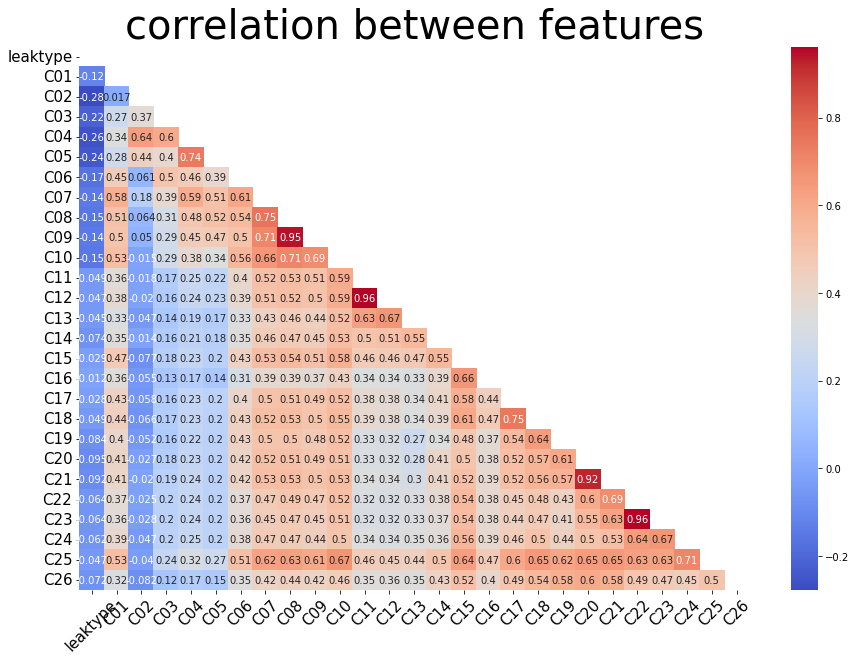

In [ ]:
plt.figure(figsize=(15,10))

heat_table = train.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

In [ ]:
# feature selection

# low variance
# from sklearn.feature_selection import VarianceThreshold

# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# selected = sel.fit_transform(train_x)
# selected.shape

# besk k
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
train_x.shape
X_new = SelectPercentile(chi2, percentile=10).fit_transform(train_x, train_y)
X_new.shape




(62564, 3)

In [ ]:
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.feature_selection import RFE
# import matplotlib.pyplot as plt

# # Create the RFE object and rank each pixel
# svc = SVC(kernel="linear", C=1)
# rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
# rfe.fit(train_x, train_y)
# ranking = rfe.ranking_.reshape(train_x.shape)

# # Plot pixel ranking
# plt.matshow(ranking, cmap=plt.cm.Blues)
# plt.colorbar()
# plt.title("Ranking of pixels with RFE")
# plt.show()

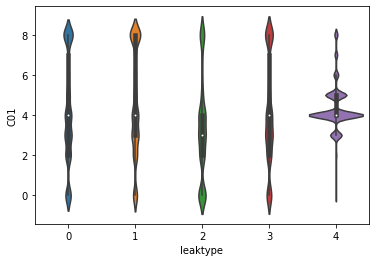

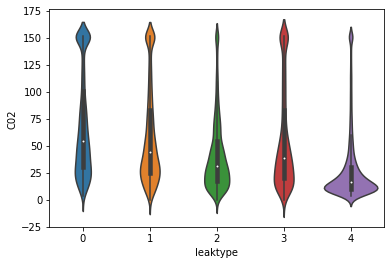

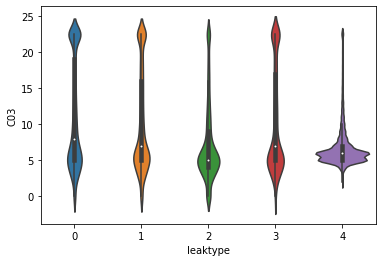

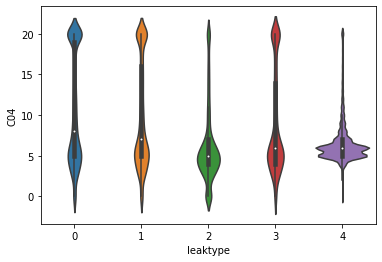

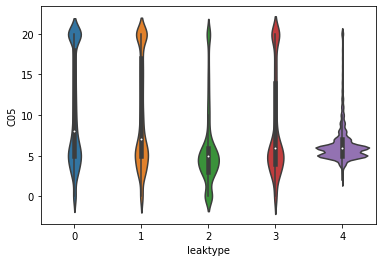

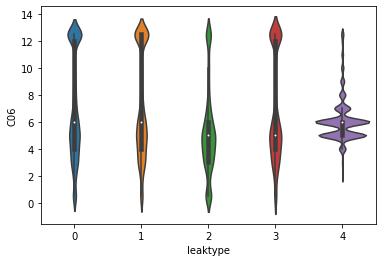

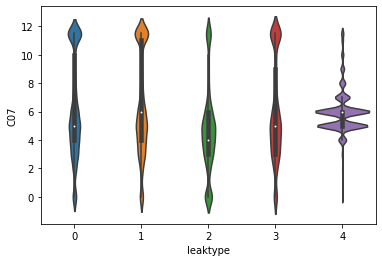

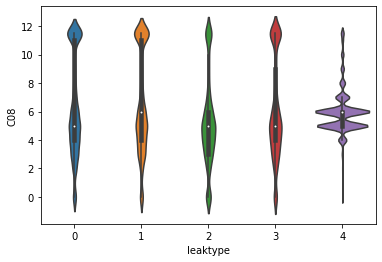

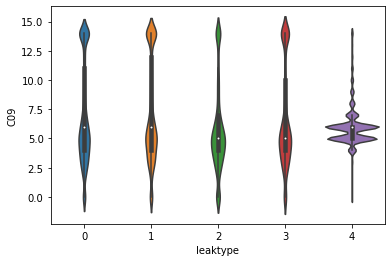

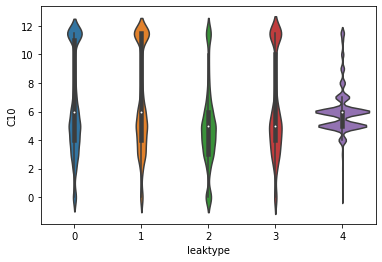

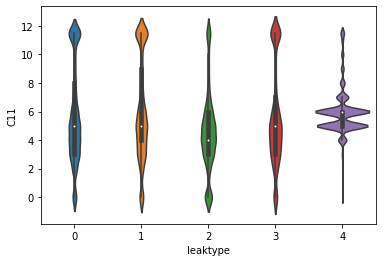

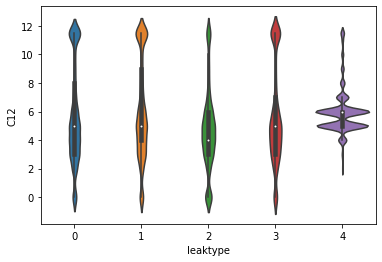

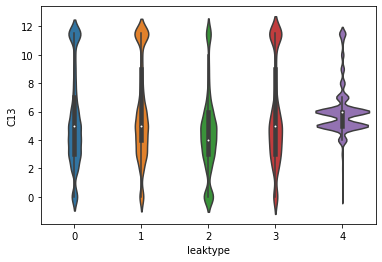

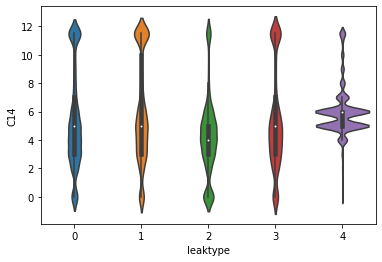

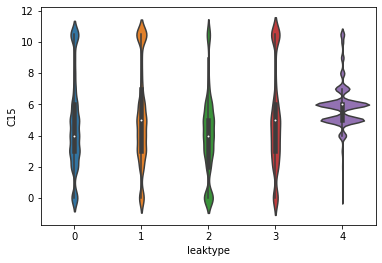

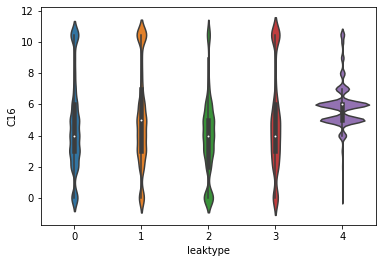

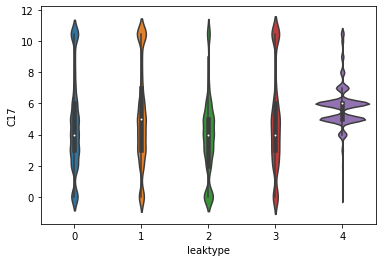

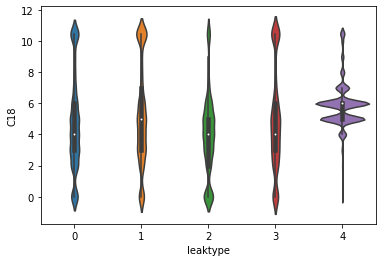

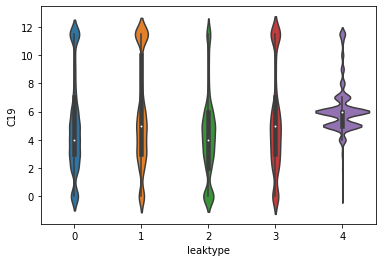

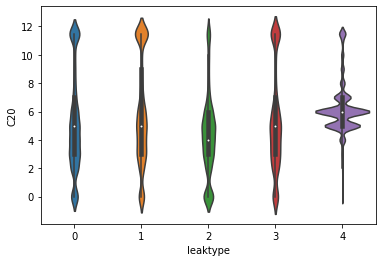

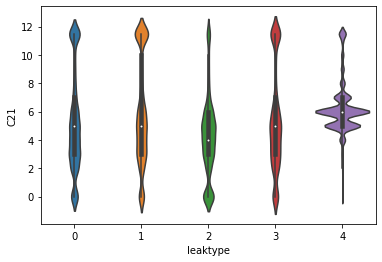

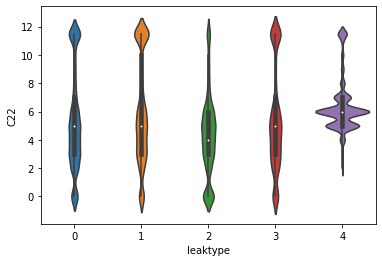

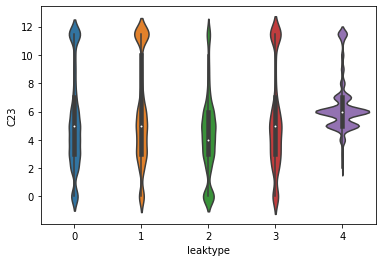

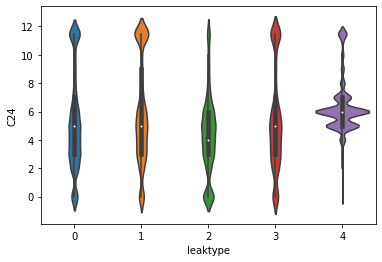

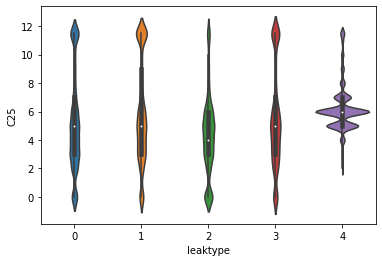

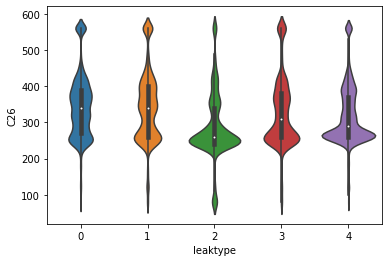

In [ ]:
# violin plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for column in train_x:
  sns.violinplot(x=train_y, y=train_x[column], data=train)
  plt.show()


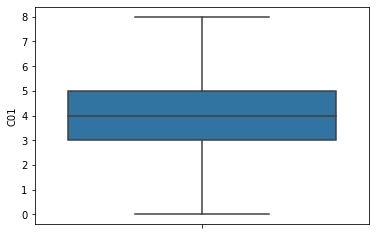

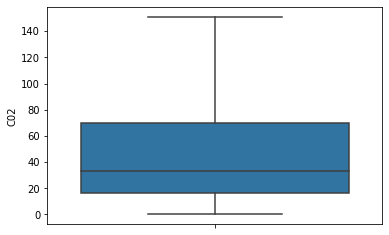

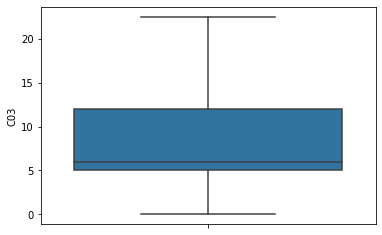

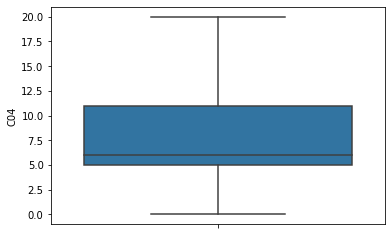

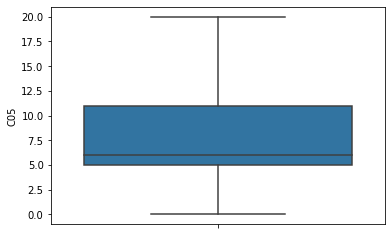

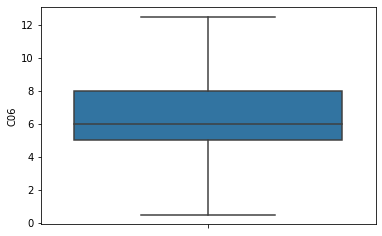

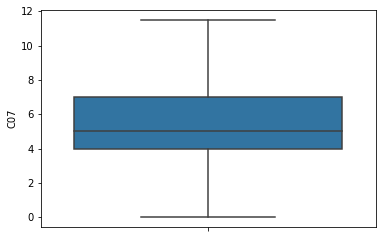

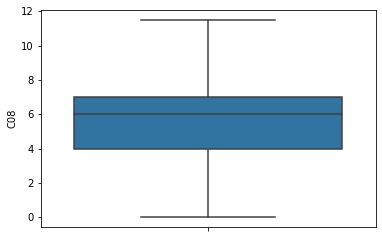

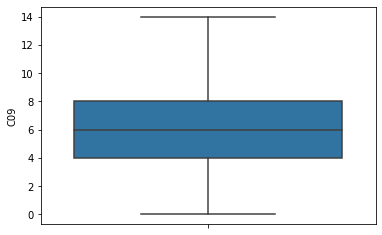

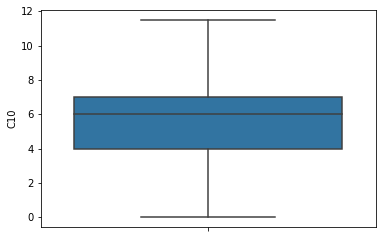

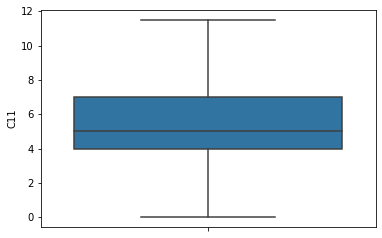

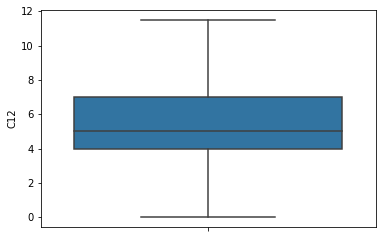

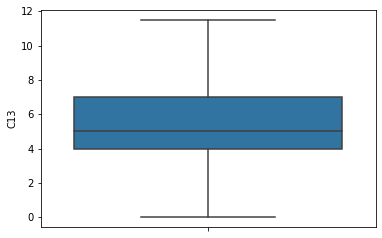

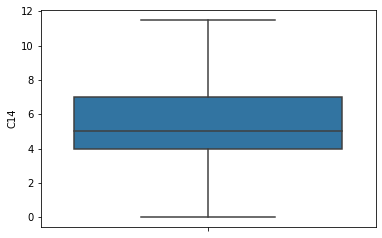

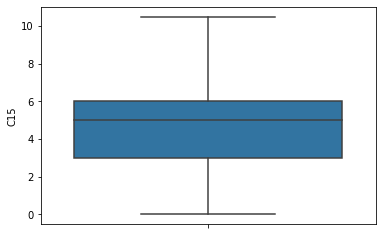

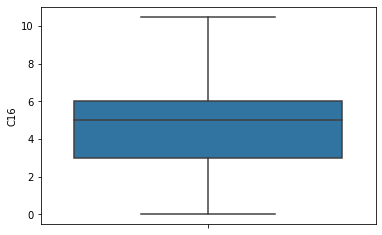

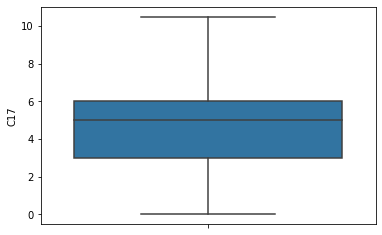

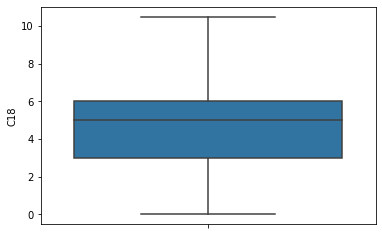

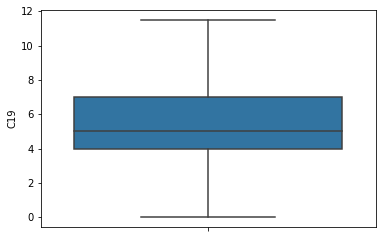

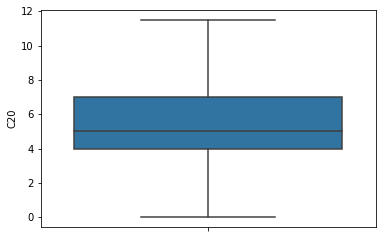

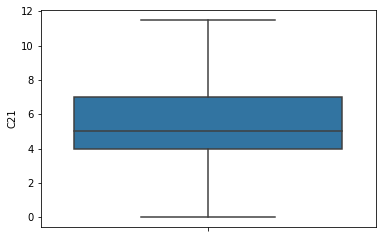

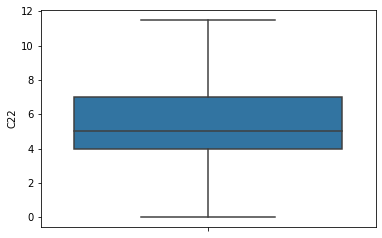

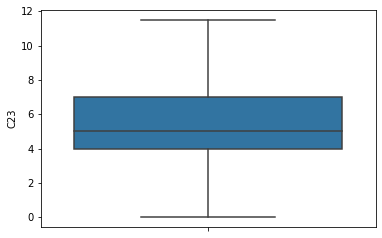

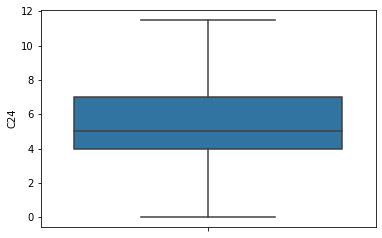

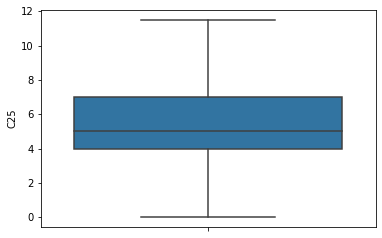

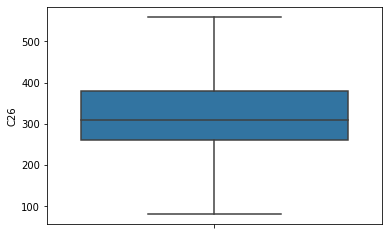

In [ ]:

for column in train_x:
  sns.boxplot(y=train_x[column])
  plt.show()